# Microhaplotypes and Sample Matching

To evaluate the utility of microhaplotype sequencing for individualization, 500 individuals were sampled randomly from a mock population of 8,000 individuals roughly matching the demographics of the United States.
Targeted Illumina MiSeq sequencing of a microhaplotype panel was simulated for these 500 individuals, and genotypes were inferred by mapping reads back to the microhap loci.

Then, for each of the 500 individuals, the sample was compared to three "background" test sets.
For each pairwise comparison, a naïve Hamming distance and the conventional RMP-based likelihood ratio test statistic were computed.

- background 1 (**reseq**): 3 replicates of simulated re-sequencing of the same individual
- background 2 (**samepop**): 3 individuals sampled randomly from the same sub-population as the focal individual
- background 3 (**allpop**): 3 individuals sampled randomly from the entire mock population

Finally, 100 pairs of individuals were sampled from the population and "mated" to create an offspring.
The offspring was then compared to each parent by computing the Hamming distance and LR test statistic (**related**).


## Hamming Distance

We define the Hamming distance between two genotype profiles as the number of loci at which the annotated alleles differ between profiles.
We do not distinguish partial allele matches ("het AB vs homo A" or "het AB vs het BC") from full mismatches ("homo A vs homo B" or "het AB vs het CD").


## LR Test Statistic

This statistic is based on comparing the likelihood of the following two hypotheses.

- $H_1$: that the test sample and a reference sample were derived from the same individual; and
- $H_0$: that the test sample and the reference sample were derived from two random (unrelated) individuals.

The probability $P(H_0)$ is the *random match probability*

$$
P_{RM} = \prod\limits_{a \in G} P(a \mid F)
$$

where $G$ is the complete genotype profile of the test sample, $a$ is an observed allele in $G$, and $P(a \mid F)$ is the population allele frequency of $a$.
The probability $P\left (H_1 \right )$ is $\epsilon^R$, where $\epsilon$ is the rate of genotyping error and $R$ is the number of mismatches between the test sample and reference sample.
Typically $R$ is expected to be either 0 (perfect matches at all loci) or very low (small number of mismatches due to genotyping error).
The likelihood ratio statistic is then computed as follows.

$$
LR = \frac{P(H_1)}{P(H_0)}
$$

Thus in the typical case when $P(H_1) = \epsilon^0 = 1$, the LR statistic is the reciprocal of the RMP.
As the number of microhaplotype loci assayed increases, $LR$ grows very rapidly, indicating that $H_1$ is the much more likely scenario.
On the other hand, when $R$ grows, $LR$ shrinks rapidly, suggesting that a sample mismatch better explains the observed differences rather than genotyping error.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import microhapulator
import numpy
import pandas
import seaborn

matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['savefig.dpi'] = 300
seaborn.set_context({"figure.figsize": (12, 8)})

## Data Import and Inspection

In [2]:
reseq = pandas.read_csv('sample-match-reseq-eval.tsv', sep='\t')
samepop = pandas.read_csv('sample-match-samepop-eval.tsv', sep='\t')
allpop = pandas.read_csv('sample-match-allpop-eval.tsv', sep='\t')
related = pandas.read_csv('sample-match-related-eval.tsv', sep='\t')

In [3]:
reseq.head()

,ID,HaploPops,TestSample,HammingDist,LRTest
0,uMOxTAD,"MHDBP000077,MHDBP000077",uMOxTAD-repl1,0,7.675932e+102
1,uMOxTAD,"MHDBP000077,MHDBP000077",uMOxTAD-repl2,0,7.675932e+102
2,uMOxTAD,"MHDBP000077,MHDBP000077",uMOxTAD-repl3,0,7.675932e+102
3,rOAtSSp,"MHDBP000022,MHDBP000032",rOAtSSp-repl1,0,6.018047e+133
4,rOAtSSp,"MHDBP000022,MHDBP000032",rOAtSSp-repl2,0,6.018047e+133


In [4]:
samepop.head()

,ID,HaploPops,TestSample,HammingDist,LRTest
0,uMOxTAD,"MHDBP000077,MHDBP000077",RjuzDui,85,0.000000e+00
1,uMOxTAD,"MHDBP000077,MHDBP000077",rQFDlqD,88,0.000000e+00
2,uMOxTAD,"MHDBP000077,MHDBP000077",cksC3EM,72,7.675932e-168
3,rOAtSSp,"MHDBP000022,MHDBP000032",i4L0t4T,77,6.018047e-176
4,rOAtSSp,"MHDBP000022,MHDBP000032",OMOB2XC,79,6.018047e-179


In [5]:
allpop.head()

,ID,HaploPops,TestSample,HammingDist,LRTest
0,uMOxTAD,"MHDBP000077,MHDBP000077",SNsOo3X,77,1.194114e-198
1,uMOxTAD,"MHDBP000077,MHDBP000077",vlBFFQu,77,1.194114e-198
2,uMOxTAD,"MHDBP000077,MHDBP000077",A2q3Egr,84,0.000000e+00
3,rOAtSSp,"MHDBP000022,MHDBP000032",jlEpKst,82,6.018040e-185
4,rOAtSSp,"MHDBP000022,MHDBP000032",XGQ6K4W,80,5.151109e-167


In [6]:
related.head()

,ID,Relative,HammingDist,LRTest
0,cJrPNQb,joFS9e9,65,7.368476e-102
1,cJrPNQb,fkvrHkG,62,7.368476e-93
2,olCqrn6,khKkVJ0,68,1.895495e-93
3,olCqrn6,kRZqYdW,75,1.895495e-114
4,CY6Zida,IgLtywv,64,7.485588e-94


## Distributions of Hamming distances

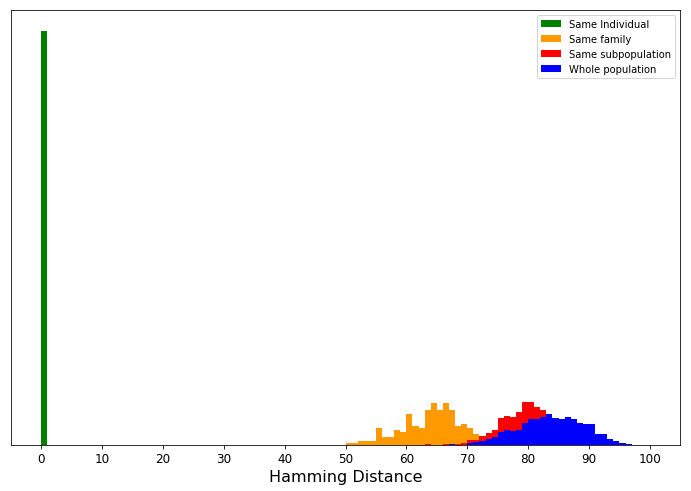

In [7]:
seaborn.set_context({"figure.figsize": (12, 8)})
_, bins, _ = plt.hist(reseq.HammingDist, range=[0, 100], bins=100, density=True, color='green', label='Same Individual')
_ = plt.hist(related.HammingDist, bins=bins, density=True, color='#FF9900', label='Same family')
_ = plt.hist(samepop.HammingDist, bins=bins, density=True, color='red', label='Same subpopulation')
_ = plt.hist(allpop.HammingDist, bins=bins, density=True, color='blue', label='Whole population')
_ = plt.yticks([])
_ = plt.xticks(range(0, 101, 10))
_ = plt.xlabel('Hamming Distance')
_ = plt.legend(loc='upper right')
_ = plt.savefig('hamming-distance.pdf')
_ = plt.show()

## Distributions of LR Test Statistics

Some of the LR test statistics are so small that they cannot be distinguished from 0.0 by the computer.
All 0.0 values were replaced by extremely low values (1e-250 for **allpop** and 1e-245 for **samepop**) to avoid problems with plotting on a log scale.

In [8]:
print(min([x for x in reseq.LRTest if x > 0.0]))
print(min([x for x in samepop.LRTest if x > 0.0]))
print(min([x for x in allpop.LRTest if x > 0.0]))
print(min([x for x in related.LRTest if x > 0.0]))

3.1951625041269066e+81
2.697104485157545e-233
1.3346815597946623e-228
1.3762676540286096e-127


In [9]:
reseq_vals = numpy.log10(reseq.LRTest)
related_vals = numpy.log10(related.LRTest)
samepop_vals = [numpy.log10(x) if x > 0.0 else -245 for x in samepop.LRTest]
allpop_vals = [numpy.log10(x) if x > 0.0 else -250 for x in allpop.LRTest]

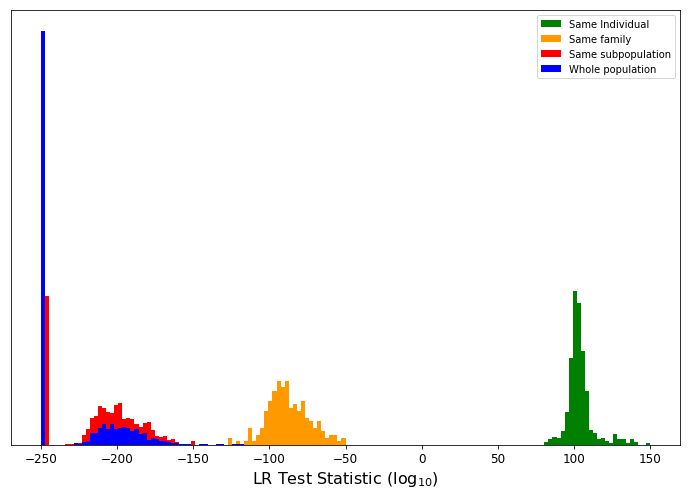

In [10]:
seaborn.set_context({"figure.figsize": (12, 8)})
_, bins, _ = plt.hist(reseq_vals, range=[-250, 150], bins=150, density=True, color='green', label='Same Individual')
_ = plt.hist(related_vals, bins=bins, density=True, color='#FF9900', label='Same family')
_ = plt.hist(samepop_vals, bins=bins, density=True, color='red', label='Same subpopulation')
_ = plt.hist(allpop_vals, bins=bins, density=True, color='blue', label='Whole population')
_ = plt.yticks([])
_ = plt.xticks(range(-250, 151, 50))
_ = plt.xlabel(r'LR Test Statistic ($\log_{10}$)')
_ = plt.legend(loc='upper right')
_ = plt.savefig('sample-matching.pdf')
_ = plt.show()